<a href="https://www.kaggle.com/code/gelgel5633/cv-torch-3-ipynb?scriptVersionId=117632207" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Getting Started with Object Detection with Pytorch
competition : Global Wheat Detection  
notebook link : https://www.kaggle.com/code/aryaprince/getting-started-with-object-detection-with-pytorch/notebook

## 소개
"밀 감지 대회"에 오신 것을 환영합니다. 야외에서의 밀의 머리부분을 탐지하는 것이 대회의 목표입니다.  
전 세계의 밀 데이터 세트를 포함하고 있습니다. 대회는 밀 머리의 크기 와 수에대한 일반적인 추정에 초점을 맞추고 있습니다.  
보이지 않는 유전자형, 환경 및 관찰 조건에 대한 성능을 더 잘 측정하기 위해 train 데이터셋은 여러 지역을 포함합니다.    
참가자는 유럽 및 북미의 3000개 이상의 이미지를 사용합니다.  
테스트 데이터에는 호주, 일본, 중국의 약 1000개의 이미지가 포함되어 있습니다.


## 지식
1. pytorch torchvision object detection 파인튜닝 튜토리얼    
링크 : https://pytorch.org/tutorials/intermediate/torchvision_tutorial    
2. nynn에 의해 쓰여진 커널  
링크 : https://www.kaggle.com/nvnnghia/fasterrcnn-pseudo-labeling  
3. 사전학습된 가중치  
링크 : https://www.kaggle.com/mathurinache/fasterrcnn  
4. fast RCNN  
링크 : https://towardsdatascience.com/faster-rcnn-object-detection-f865e5ed7fc4  

## 목차  
1. EDA
2. 우리의 작업에 해당하는 custom dataset 작성
3. 모델 정의
4. 사전학습된 모델로부터의 파인튜닝
5. 예측
6. End Note

# 1. EDA
필요한 라이브러리를 설치하고 불러옵니다.

In [66]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# /kaggle/input/global-wheat-detection/sample_submission.csv
# /kaggle/input/global-wheat-detection/train.csv
# /kaggle/input/global-wheat-detection/test/796707dd7.jpg
# 등의 파일을 불러왔습니다. jpg파일은 이외에도 여러 가지가 존재합니다.

In [67]:
import cv2 
import os 
import re
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt

In [68]:
WEIGHTS_FILE = '/kaggle/input/fasterrcnn/fasterrcnn_resnet50_fpn_best.pth'

### train, test 파일 불러오기

In [69]:
train_df = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
submit = pd.read_csv("/kaggle/input/global-wheat-detection/sample_submission.csv")

In [70]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [71]:
# 원하지 않는 컬럼을 제거합니다.
train_df = train_df.drop(columns=['width', 'height','source'])

In [72]:
# train데이터셋에는 3373개의 고유 이미지가 존재합니다.
train_df["image_id"].nunique()

3373

In [73]:
# 한 개의 이미지에서 최대 박스의 갯수는 116개 입니다.
(train_df["image_id"].value_counts()).max()

116

[xmin, ymin, w, h] 형식으로 상자의 dimension을 분할합니다.    
나중에 dimension을 [xmin,ymin,xmax,ymax]로 변환할 것입니다.

In [74]:
train_df["x"] = -1
train_df["y"] = -1
train_df["w"] = -1
train_df["h"] = -1


# bbox의 형식은 [834.0, 222.0, 56.0, 36.0] 입니다.
# re.findall은 list 형태로 반환됩니다.
def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1,-1,-1,-1]
    return r

In [75]:
# re.findall이 list형태로 반환되는데, 각 값을 x,y,w,h로 할당합니다.
train_df[["x","y","w","h"]] = np.stack(train_df["bbox"].apply(lambda x: expand_bbox(x)))

train_df["x"] = train_df["x"].astype(np.float)
train_df["y"] = train_df["y"].astype(np.float)
train_df["w"] = train_df["w"].astype(np.float)
train_df["h"] = train_df["h"].astype(np.float)

In [76]:
train_df.head()

,image_id,bbox,x,y,w,h
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,56.0,36.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,130.0,58.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,74.0,160.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,109.0,107.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,124.0,117.0


train과 val 셋으로 나눕니다.

In [77]:
image_ids = train_df["image_id"].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df["image_id"].isin(valid_ids)]
train_df = train_df[train_df["image_id"].isin(train_ids)]

In [78]:
# 이미지에 transform(변형?) 을 적용합니다.
trans = transforms.Compose([transforms.ToTensor()])

# 2. 우리의 작업에 해당하는 custom dataset 작성
2.1 train 및 validation 이미지에대한 데이터 세트 생성

In [86]:
class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None,train=True):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.train=train

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self, index : int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        # 정규화
        image /= 255.0
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        # test 데이터일 경우
        if (self.train==False):
            return image, image_id
        
        # train 데이터일 경우
        records = self.df[self.df["image_id"] == image_id]
        
        boxes = records[["x","y","w","h"]].values
        
        # w = x + w
        # h = y + h
        # area를 구하기 위해서 설정. -> x,y,w,h 모두 시작하는 점에서 가까운 곳에 지정된 것으로 보임
        boxes[:,2] = boxes[:,0] + boxes[:,2]
        boxes[:,3] = boxes[:,1] + boxes[:,3]
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        
        # 넓이 = (h-y) * (w-x)
        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        area = torch.as_tensor(area, dtype = torch.float32)
        
        # 오직 한 개의 클래스만 존재함
        labels = torch.ones((records.shape[0],), dtype = torch.int64)
        
        # 모든 인스턴스가 다수(crowd로 적혀있음)가 아니라고 가정
        iscrowd = torch.zeros((records.shape[0],), dtype = torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([index])
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return image, target, image_id

In [87]:
train_dir = '/kaggle/input/global-wheat-detection/train'
test_dir = '/kaggle/input/global-wheat-detection/test'

In [88]:
# 평균 loss값 리턴
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations +=1
        
    # 데코레이터. setter, getter와 관련 -> 매서드를 통해 속성의 값을 가져오거나 저장할 때 사용
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
        
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [89]:
train_dataset = WheatDataset(train_df, train_dir, trans,True)
valid_dataset = WheatDataset(valid_df, train_dir, trans,True)

In [90]:
# torch.randperm(n) -> n개의 랜덤한 정수 순열 생성인데, 사용되지는 않음
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

바운딩박스와 함께 시각화를 해봅시다

In [91]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

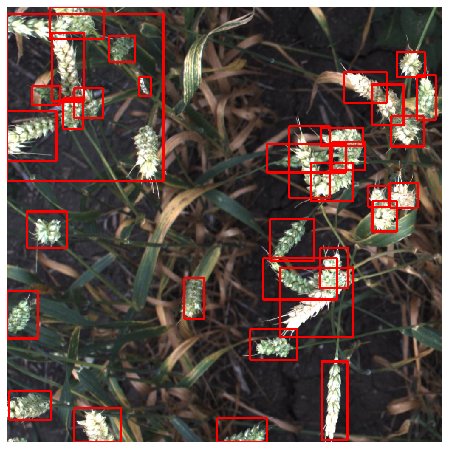

In [92]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

boxes = targets[4]["boxes"].cpu().numpy().astype(np.int32)
sample = images[4].permute(1,2,0).cpu().numpy()

fig,ax = plt.subplots(1,1, figsize=(16,8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), 
                 (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# 3. 모델 파인튜닝  
### 모델 정의하기  
faster R-CNN은 이미지의 잠재적 개체에 대한 boundingbox와 클래스 점수 모두를 예측하는 모델입니다.  
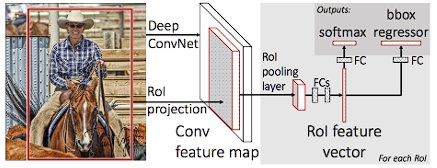  

  
이 구조가 어떻게 작동하는지 설명하겠습니다.  
Faster RCNN은 세 부분으로 구성됩니다.

1. 합성곱레이어 : CNN 구조는 차별화 가능한 함수를 통해 입력 볼륨을 출력 볼륨으로 변환하는 별개의 레이어 스택으로 구성됩니다. 합성곱 네트워크는 뉴런 간의 연결패턴이 동물 시각 피질의 조직과 유사하다는 생물학적 과정에서 영감을 받았습니다. 개별 뉴런은 수용 영역으로 알려진 시야의 제한된 영역에서만 자극에 반응합니다. 서로 다른 뉴런의 수용 영역은 전체 시야를 덮도록 부분적으로 겹칩니다. 

2. RPN(region proposel network) : 합성곱 레이어의 마지막 피쳐맵에서 작은 신경망으로, 객체의 존재 여부를 예측하고 해당 객체의 경계 상자를 예측합니다.  

3. 바운딩 박스 및 클래스 예측 : 우리는 RPN에 의해 제안된 영역을 input으로 취하고, 객체 클래스와 바운딩 박스를 예측하는 완전 연결 신경망을 사용합니다.  


torchvision modelzoo에서 사용가능한 모델 중 하나를 수정하려는 두 가지 일반적인 상황이 있습니다. 첫 번째는 미리 훈련된 모델에서 시작하여 마지막 레이어를 미세 조정하려는 경우입니다.  
다른 하나는 모델의 백본을 다른 모델로 교체하려는 경우입니다. 우리의 경우 데이터 세트가 매우 작기 때문에 미리 훈련된 모델에서 미세조정하기를 원하므로 접근 번호를 따를 것입니다.

In [93]:
# coco에서 사전학습된 모델 불러오기
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False, pretrained_backbone = False)

라벨에 대해 주목할 점. 모델은 클래스 0을 배경으로 간주합니다. 데이터 세트에 백그라운드 클래스가 포함되어 있지 않으면 라벨에 0이 없어야 합니다.  
예를 들어, 고양이와 개라는 두 개의 클래스만 있다고 가정하면, 고양이를 나타내기위해 1(0이 아님)을 정의하고 개를 나타내기 위해 2를 정의할 수 있습니다. 이미지 하나에 두 가지 클래스가 있다면 라벨 텐서는 [1,2] 의 형식이어야 합니다.  
우리의 경우 클래스 수는 2, 백그라운드 클래스는0, 밀은 1입니다.

In [94]:
num_classes = 2 # 1 class (밀) + 배경

# 분류기의 입력 피쳐 수 가져오기
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 사전 훈련된 헤드를 새 헤드로 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 사전 학습된 가중치 불러오기
model.load_state_dict(torch.load(WEIGHTS_FILE))

<All keys matched successfully>

모델 훈련 시작

In [ ]:
model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.01, momentum = 0.9, weight_decay = 0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.5)

num_epochs = 5

loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 0.7214982509613037
Iteration #100 loss: 0.5525983572006226
Iteration #150 loss: 0.505117654800415
Epoch #0 loss: 0.6028812620569678
Iteration #200 loss: 0.6316407322883606
Iteration #250 loss: 0.5105282068252563


# 4. 예측  
test 데이터를 불러옵니다.

In [ ]:
test_dataset = WheatDataset(submit,test_dir, trans,False)

test_data_loader = DataLoader( test_dataset, batch_size=8, shuffle=False)

바운딩 박스를 예측하기 위한 임계값을 설정합니다.

In [ ]:
detection_threshold = 0.45

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [ ]:
results=[]
model.eval()

for images, image_ids in test_data_loader:    

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()    ##Formate of the output's box is [Xmin,Ymin,Xmax,Ymax]
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        image_id = image_ids[i]
        
        # box 형식을 [xmin, ymin, w, h] 로 변환합니다.
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]         
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]         
        
            
        result = { 
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

In [ ]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

예측결과를 시각화 해봅니다

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

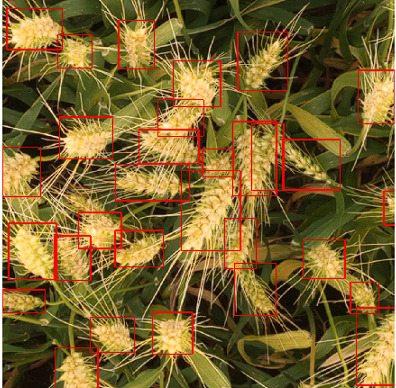

## 제출

In [ ]:
test_df.to_csv('submission.csv', index=False)